
# Decomposition, Detrending, Deseasonalizing, and Testing WSS

This notebook demonstrates a complete workflow to:
1. Simulate a time series with **trend**, **seasonality**, and **noise**.
2. **Decompose** the series (classical & STL) and extract residuals.
3. **Detrend / deseasonalize** via polynomial + Fourier and via **differencing**.
4. **Test weak-sense stationarity (WSS)** of residuals:
   - **ADF** (Augmented Dickey–Fuller): evidence of nonstationarity in the mean/trend.
   - **KPSS** (Kwiatkowski–Phillips–Schmidt–Shin): evidence *for* stationarity around a level (small p ⇒ reject stationarity).
   - **ARCH LM**: test for time-varying variance (conditional heteroskedasticity).
5. Visual diagnostics: **rolling mean/variance** only (no ACF/PACF in this annotated version).

**How to read the tests (rule-of-thumb, α = 0.05):**
- **ADF**: small p ⇒ reject nonstationarity; large p ⇒ likely trend/nonstationary mean.
- **KPSS** (level): small p ⇒ reject stationarity around a constant level.
- **ARCH LM**: small p ⇒ variance changes over time (heteroskedasticity).

> Requirements: `numpy`, `pandas`, `matplotlib`, `statsmodels`.



## Imports and helper functions

We set up plotting defaults and define two helper functions:
- `show_series`: quick line plot
- `summary_tests`: runs ADF, KPSS(level), Ljung–Box, and ARCH LM, and prints p-values.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tools.sm_exceptions import InterpolationWarning

plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "figure.dpi": 300,
    "axes.grid": True
})

# Ignore only InterpolationWarning
warnings.filterwarnings("ignore", category=InterpolationWarning)

def show_series(y, title="", xlabel="t", ylabel="Y_t", fontsize=14):
    fig, ax = plt.subplots()
    ax.plot(y, lw=1.2)
    ax.set_title(f"{title}", fontsize=fontsize) if title else None
    if xlabel:
        ax.set_xlabel(f"${xlabel}$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(f"${ylabel}$", fontsize=fontsize)
    plt.show()

def summary_tests(y, lags=20, alpha=0.05, name="Series"):
    print(f"=== Tests for {name} ===")

    # ADF (nonstationarity in mean)
    adf_stat, adf_p, _, _, _, _ = adfuller(y, autolag="AIC")
    print(f"ADF: stat={adf_stat:.3f}, p={adf_p:.3g}")
    if adf_p < alpha:
        print(" => Reject nonstationarity: series likely stationary in the mean.")
    else:
        print(" => Fail to reject nonstationarity: mean may have a trend/unit root.")

    # KPSS (stationarity around a level)
    kpss_stat, kpss_p, _, _ = kpss(y, regression="c", nlags="auto")
    print(f"KPSS(level): stat={kpss_stat:.3f}, p={kpss_p:.3g}")
    if kpss_p < alpha:
        print(" => Reject stationarity: mean is not constant (trend/nonstationary).")
    else:
        print(" => Fail to reject stationarity: mean appears constant.")

    # ARCH LM (time-varying variance)
    arch_stat, arch_p, _, _ = het_arch(y)
    print(f"ARCH LM: stat={arch_stat:.3f}, p={arch_p:.3g}")
    if arch_p < alpha:
        print(" => Reject homoskedasticity: variance changes over time.")
    else:
        print(" => Fail to reject homoskedasticity: variance appears constant.")

    print()



## 1) Simulate a series with trend + seasonality + noise

We generate an additive series $Y_t = 0.05\,t + 2\sin(2\pi t/24) + \varepsilon_t,\quad \varepsilon_t \sim \mathcal{N}(0,1)$.
We then **visualize** it and run the four tests to see the typical nonstationary signatures.


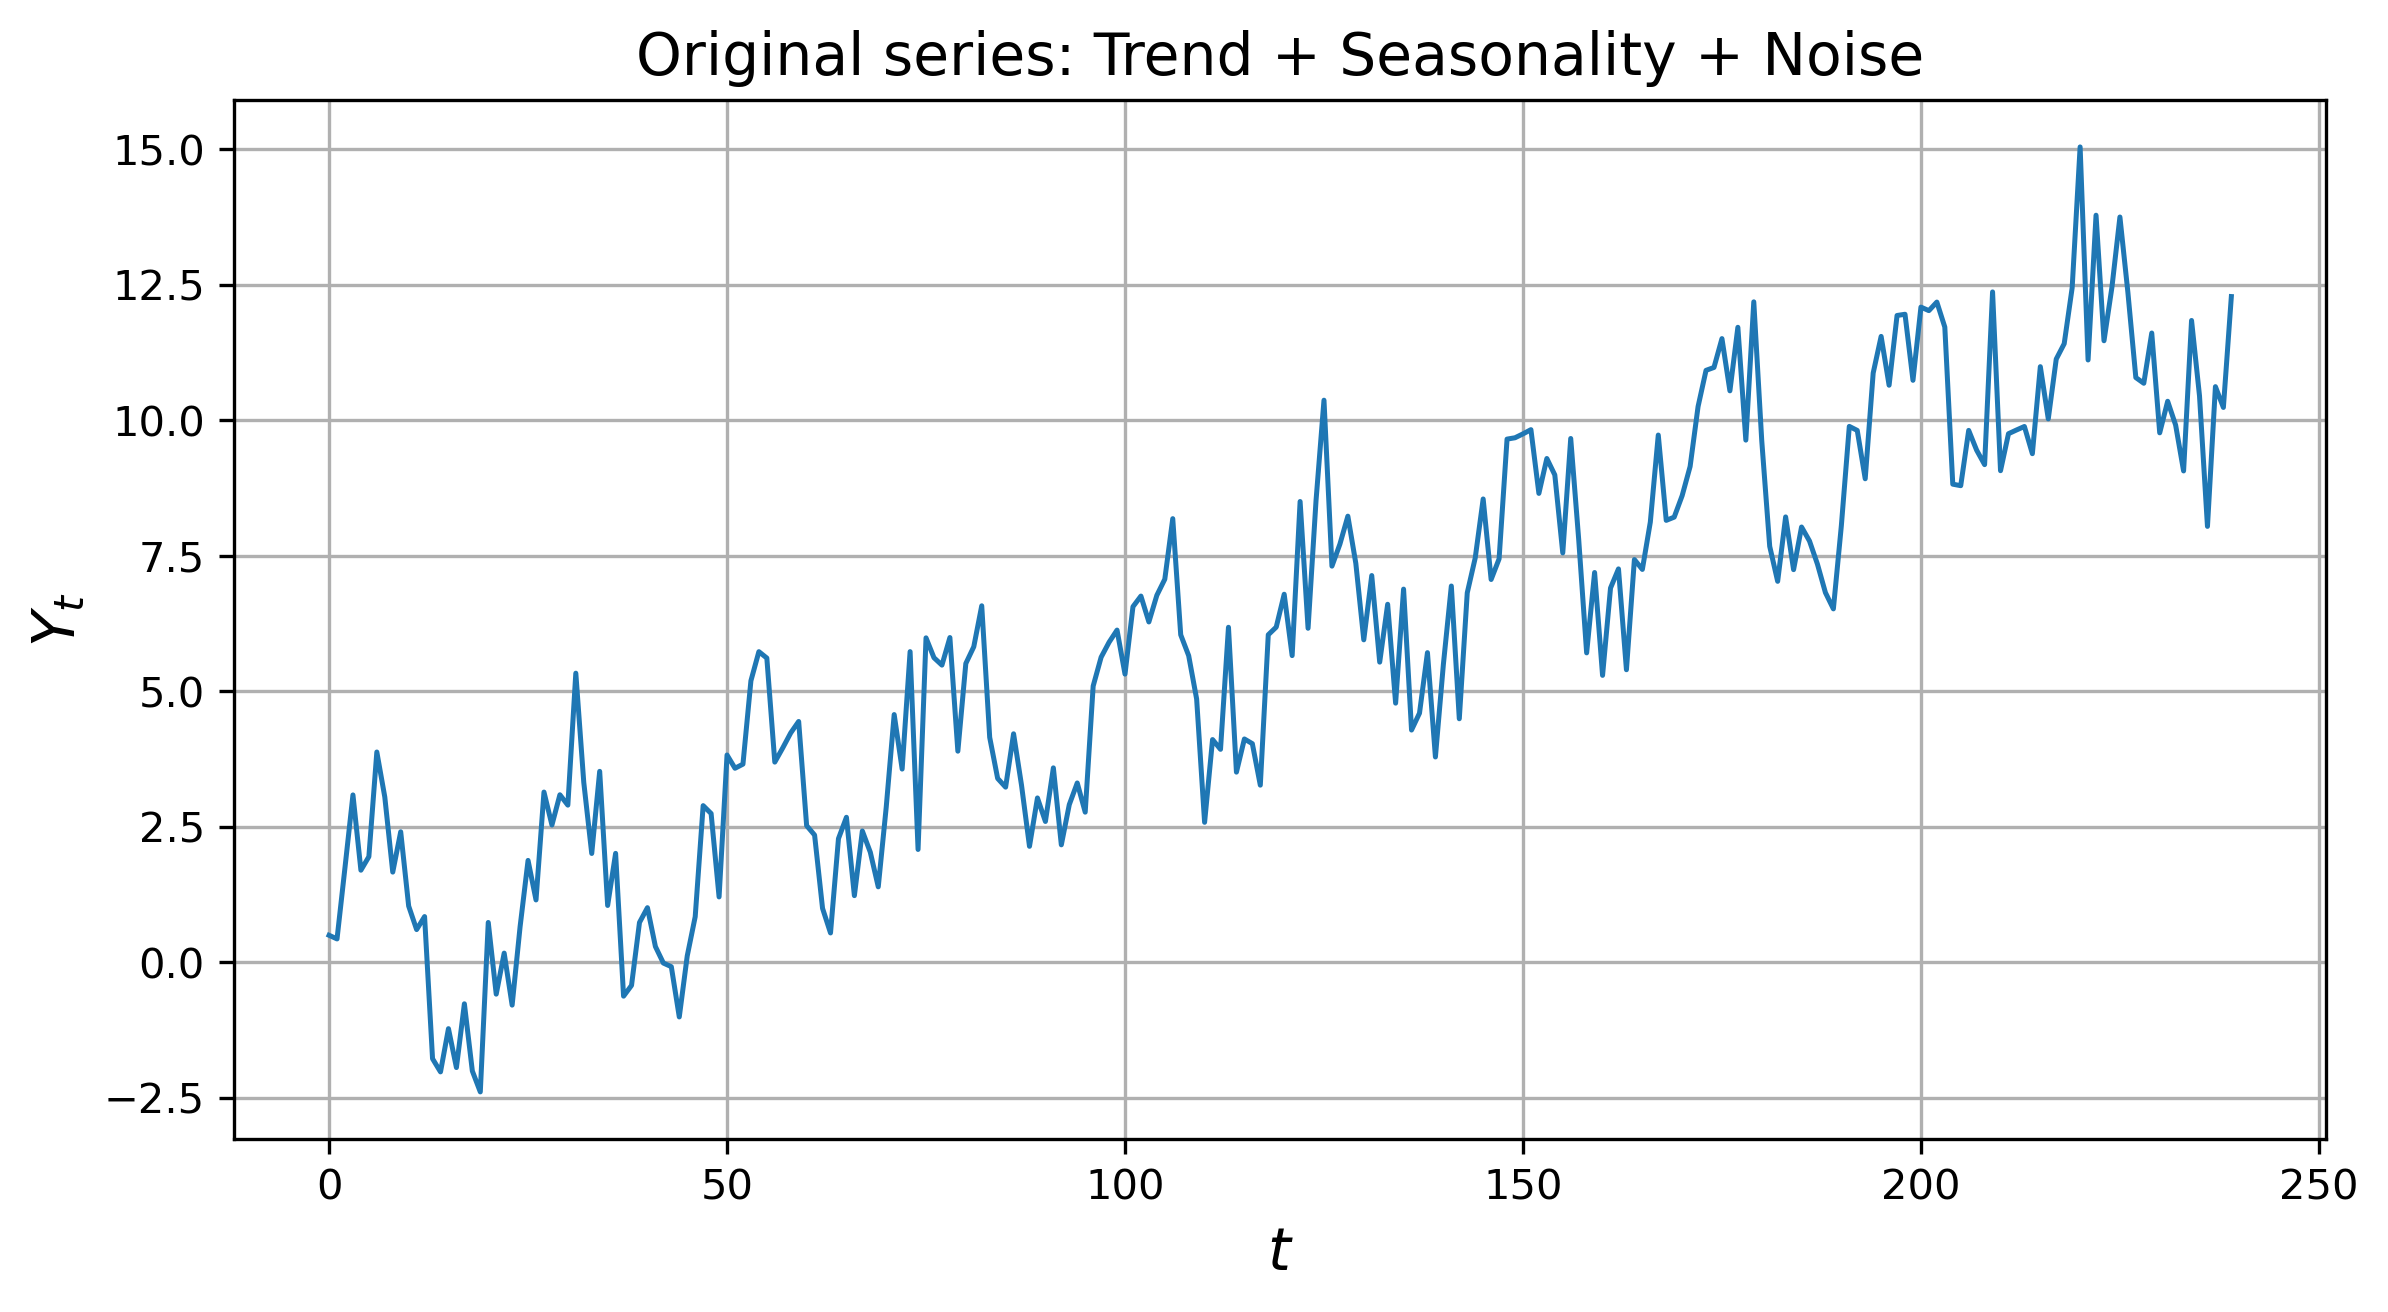

=== Tests for Original series ===
ADF: stat=-0.777, p=0.826
 => Fail to reject nonstationarity: mean may have a trend/unit root.
KPSS(level): stat=2.091, p=0.01
 => Reject stationarity: mean is not constant (trend/nonstationary).
ARCH LM: stat=194.684, p=2.07e-36
 => Reject homoskedasticity: variance changes over time.



In [2]:
np.random.seed(42)
T = 240
t = np.arange(T)
trend = 0.05 * t
period = 24
seasonal = 2.0 * np.sin(2*np.pi*t/period)
noise = np.random.normal(0, 1.0, size=T)

Y = trend + seasonal + noise
ts = pd.Series(Y, index=pd.RangeIndex(start=0, stop=T, step=1), name="Y")

show_series(ts, title="Original series: Trend + Seasonality + Noise")
summary_tests(ts, lags=24, name="Original series")


## 2) Decompose (classical and STL) and extract residuals

We perform both **classical additive decomposition** and **STL**, then extract **residuals** (noise)
and test them. A good decomposition should remove most trend/seasonality so that residuals look WSS.

- **Classical additive decomposition** assumes
  $$
  Y_t = T_t + S_t + R_t,
  $$
  where $T_t$ is a smooth **trend**, $S_t$ is a repeating **seasonal component** with fixed period,
  and $R_t$ is the remaining **residual/noise**.
  It uses moving averages to estimate trend and seasonal components.

- **STL (Seasonal-Trend decomposition using Loess)** is a more flexible and robust version:
  - Uses local regression (Loess) smoothing instead of simple moving averages.
  - Can handle complex or changing seasonal patterns.
  - Provides robustness to outliers and more control over smoothing.

In both cases, the goal is to isolate the **residuals** $R_t$, which ideally behave like a
WSS noise process. We will now extract and test those residuals.

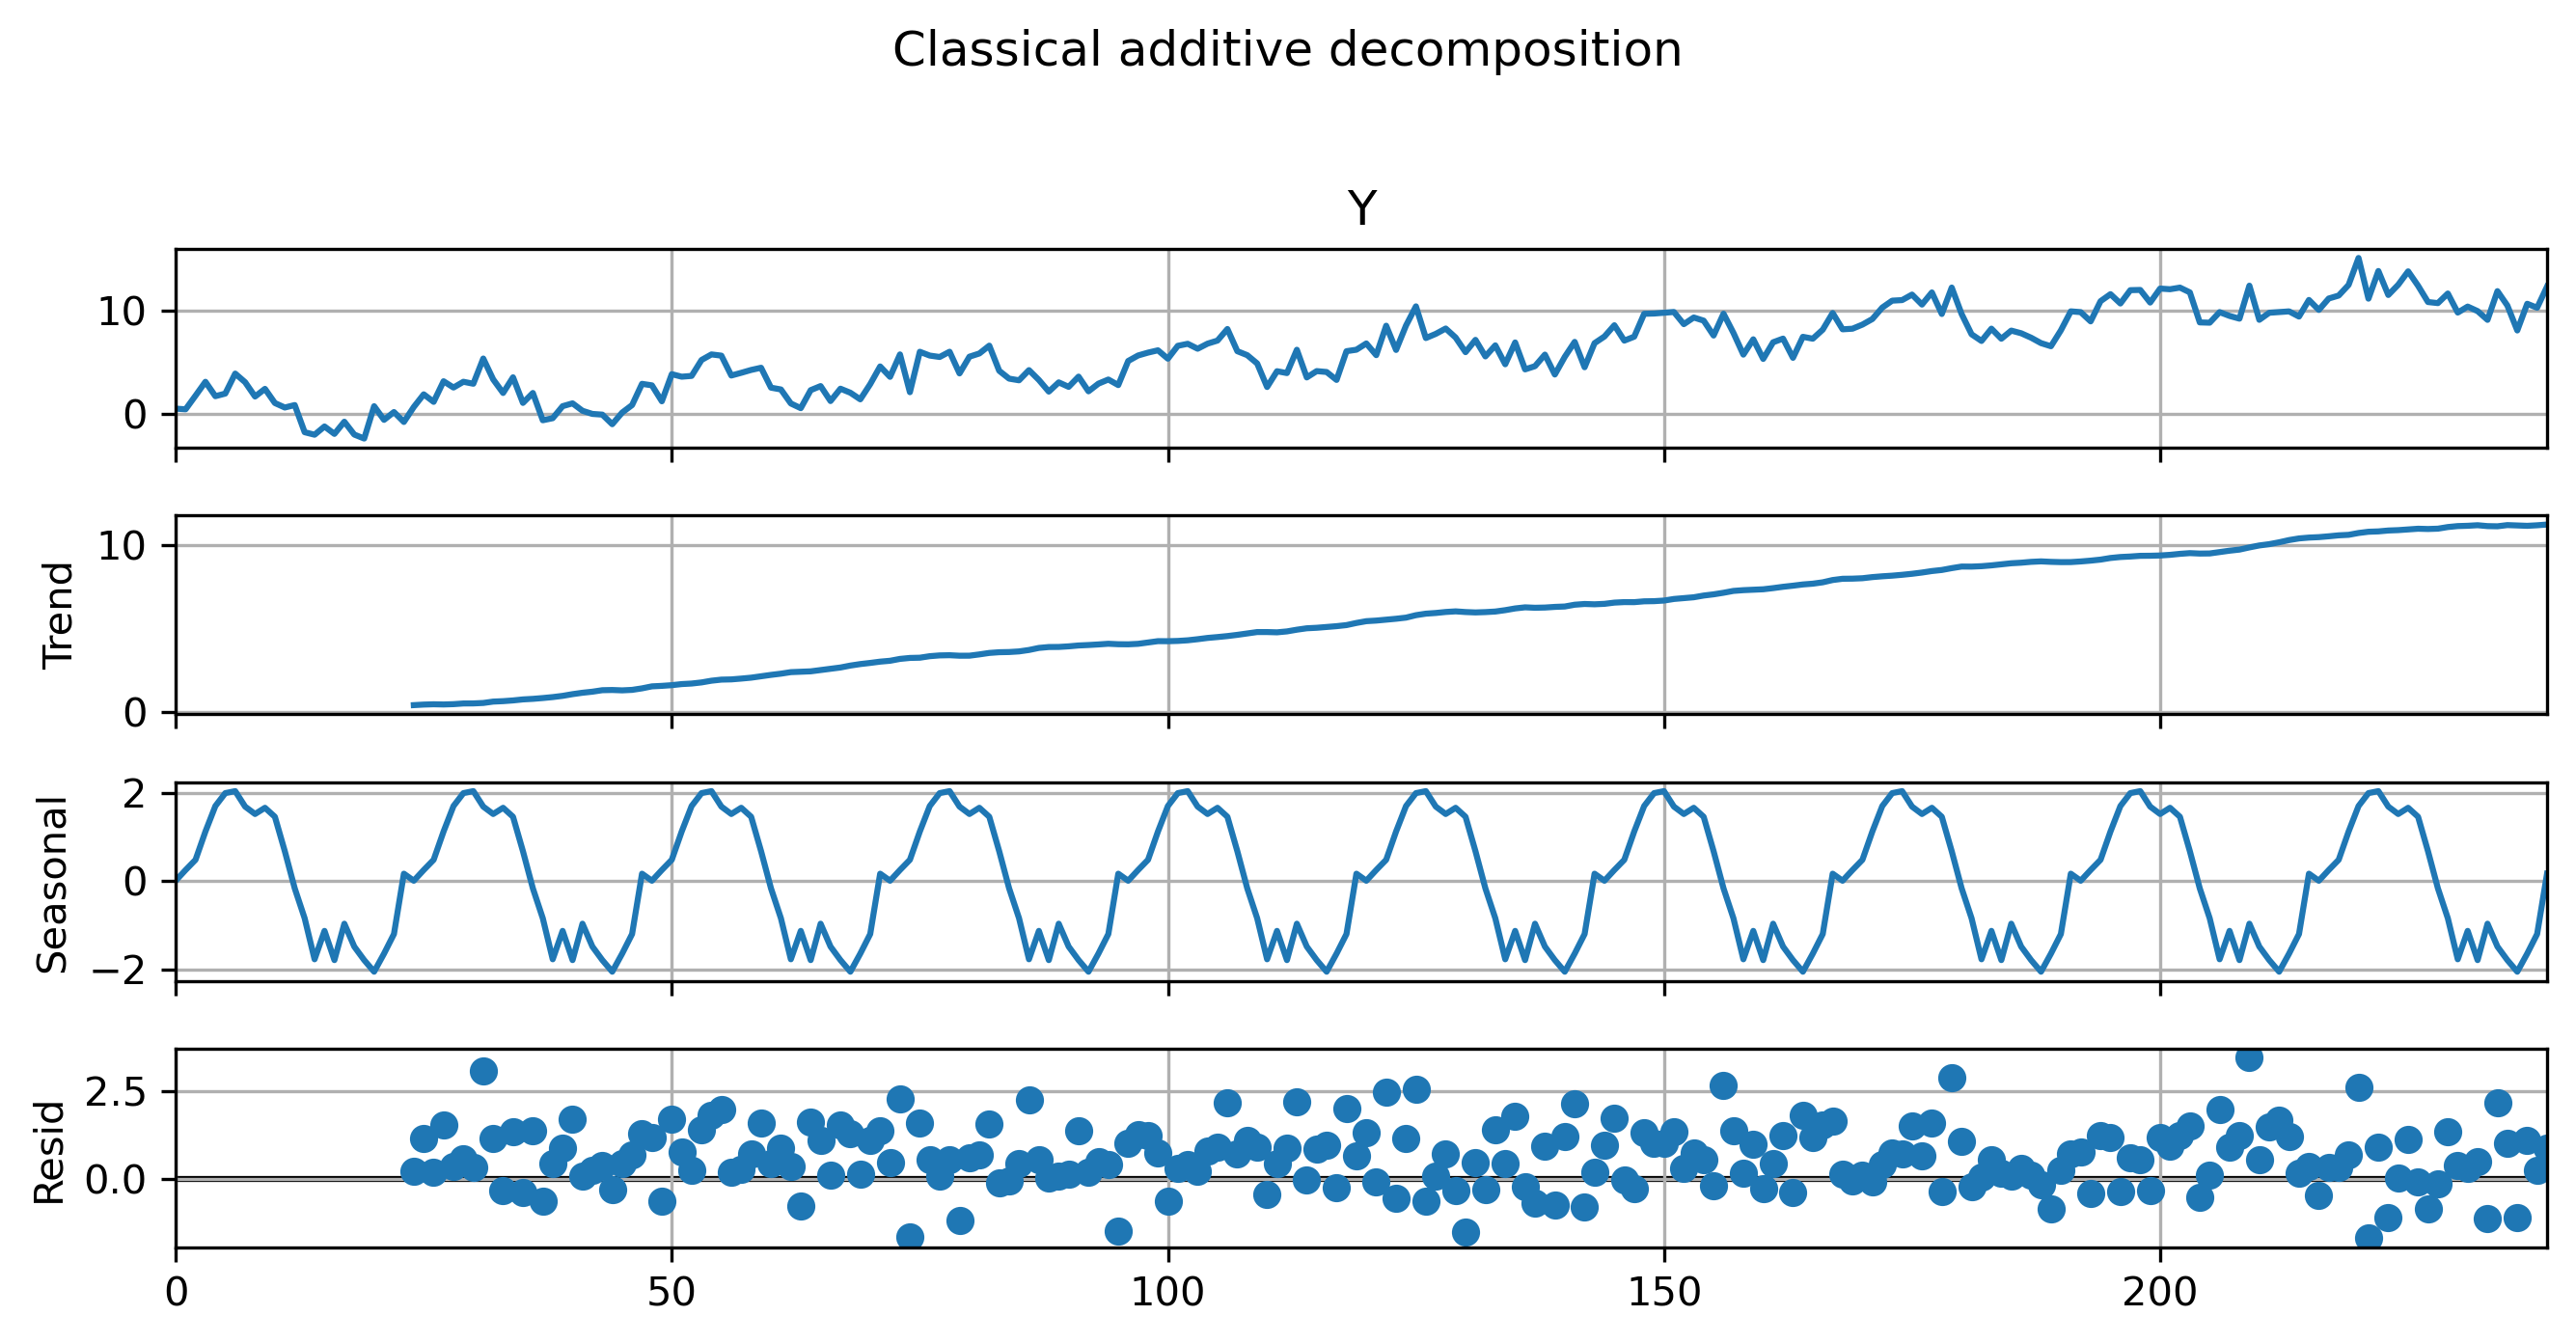

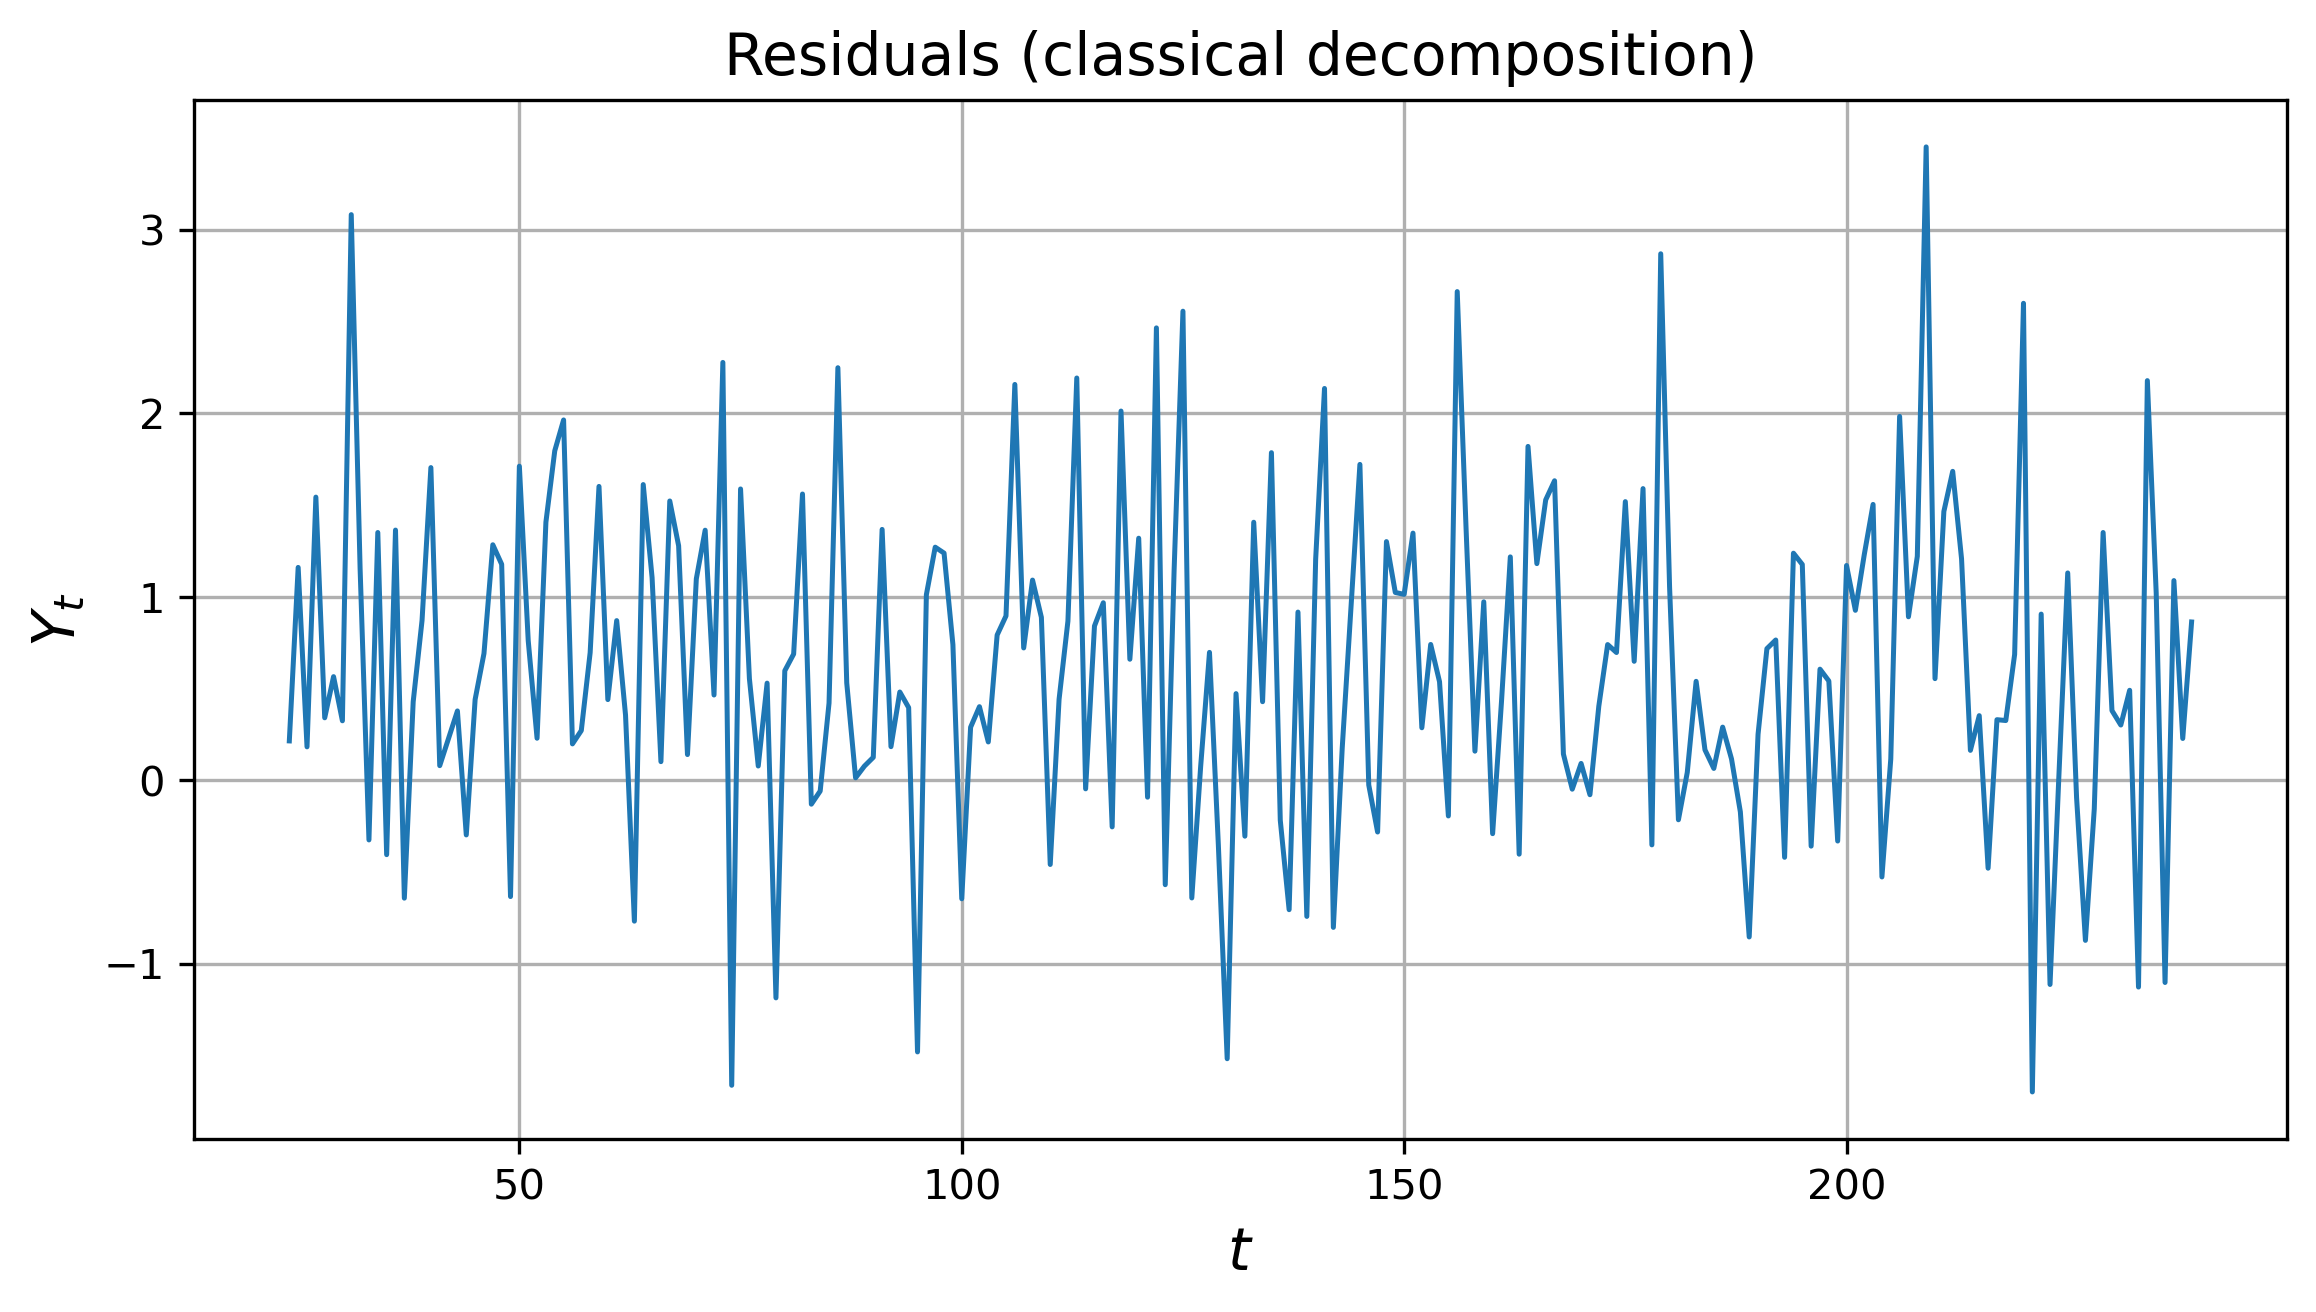

=== Tests for Residuals (classic) ===
ADF: stat=-16.596, p=1.78e-29
 => Reject nonstationarity: series likely stationary in the mean.
KPSS(level): stat=0.106, p=0.1
 => Fail to reject stationarity: mean appears constant.
ARCH LM: stat=7.290, p=0.698
 => Fail to reject homoskedasticity: variance appears constant.



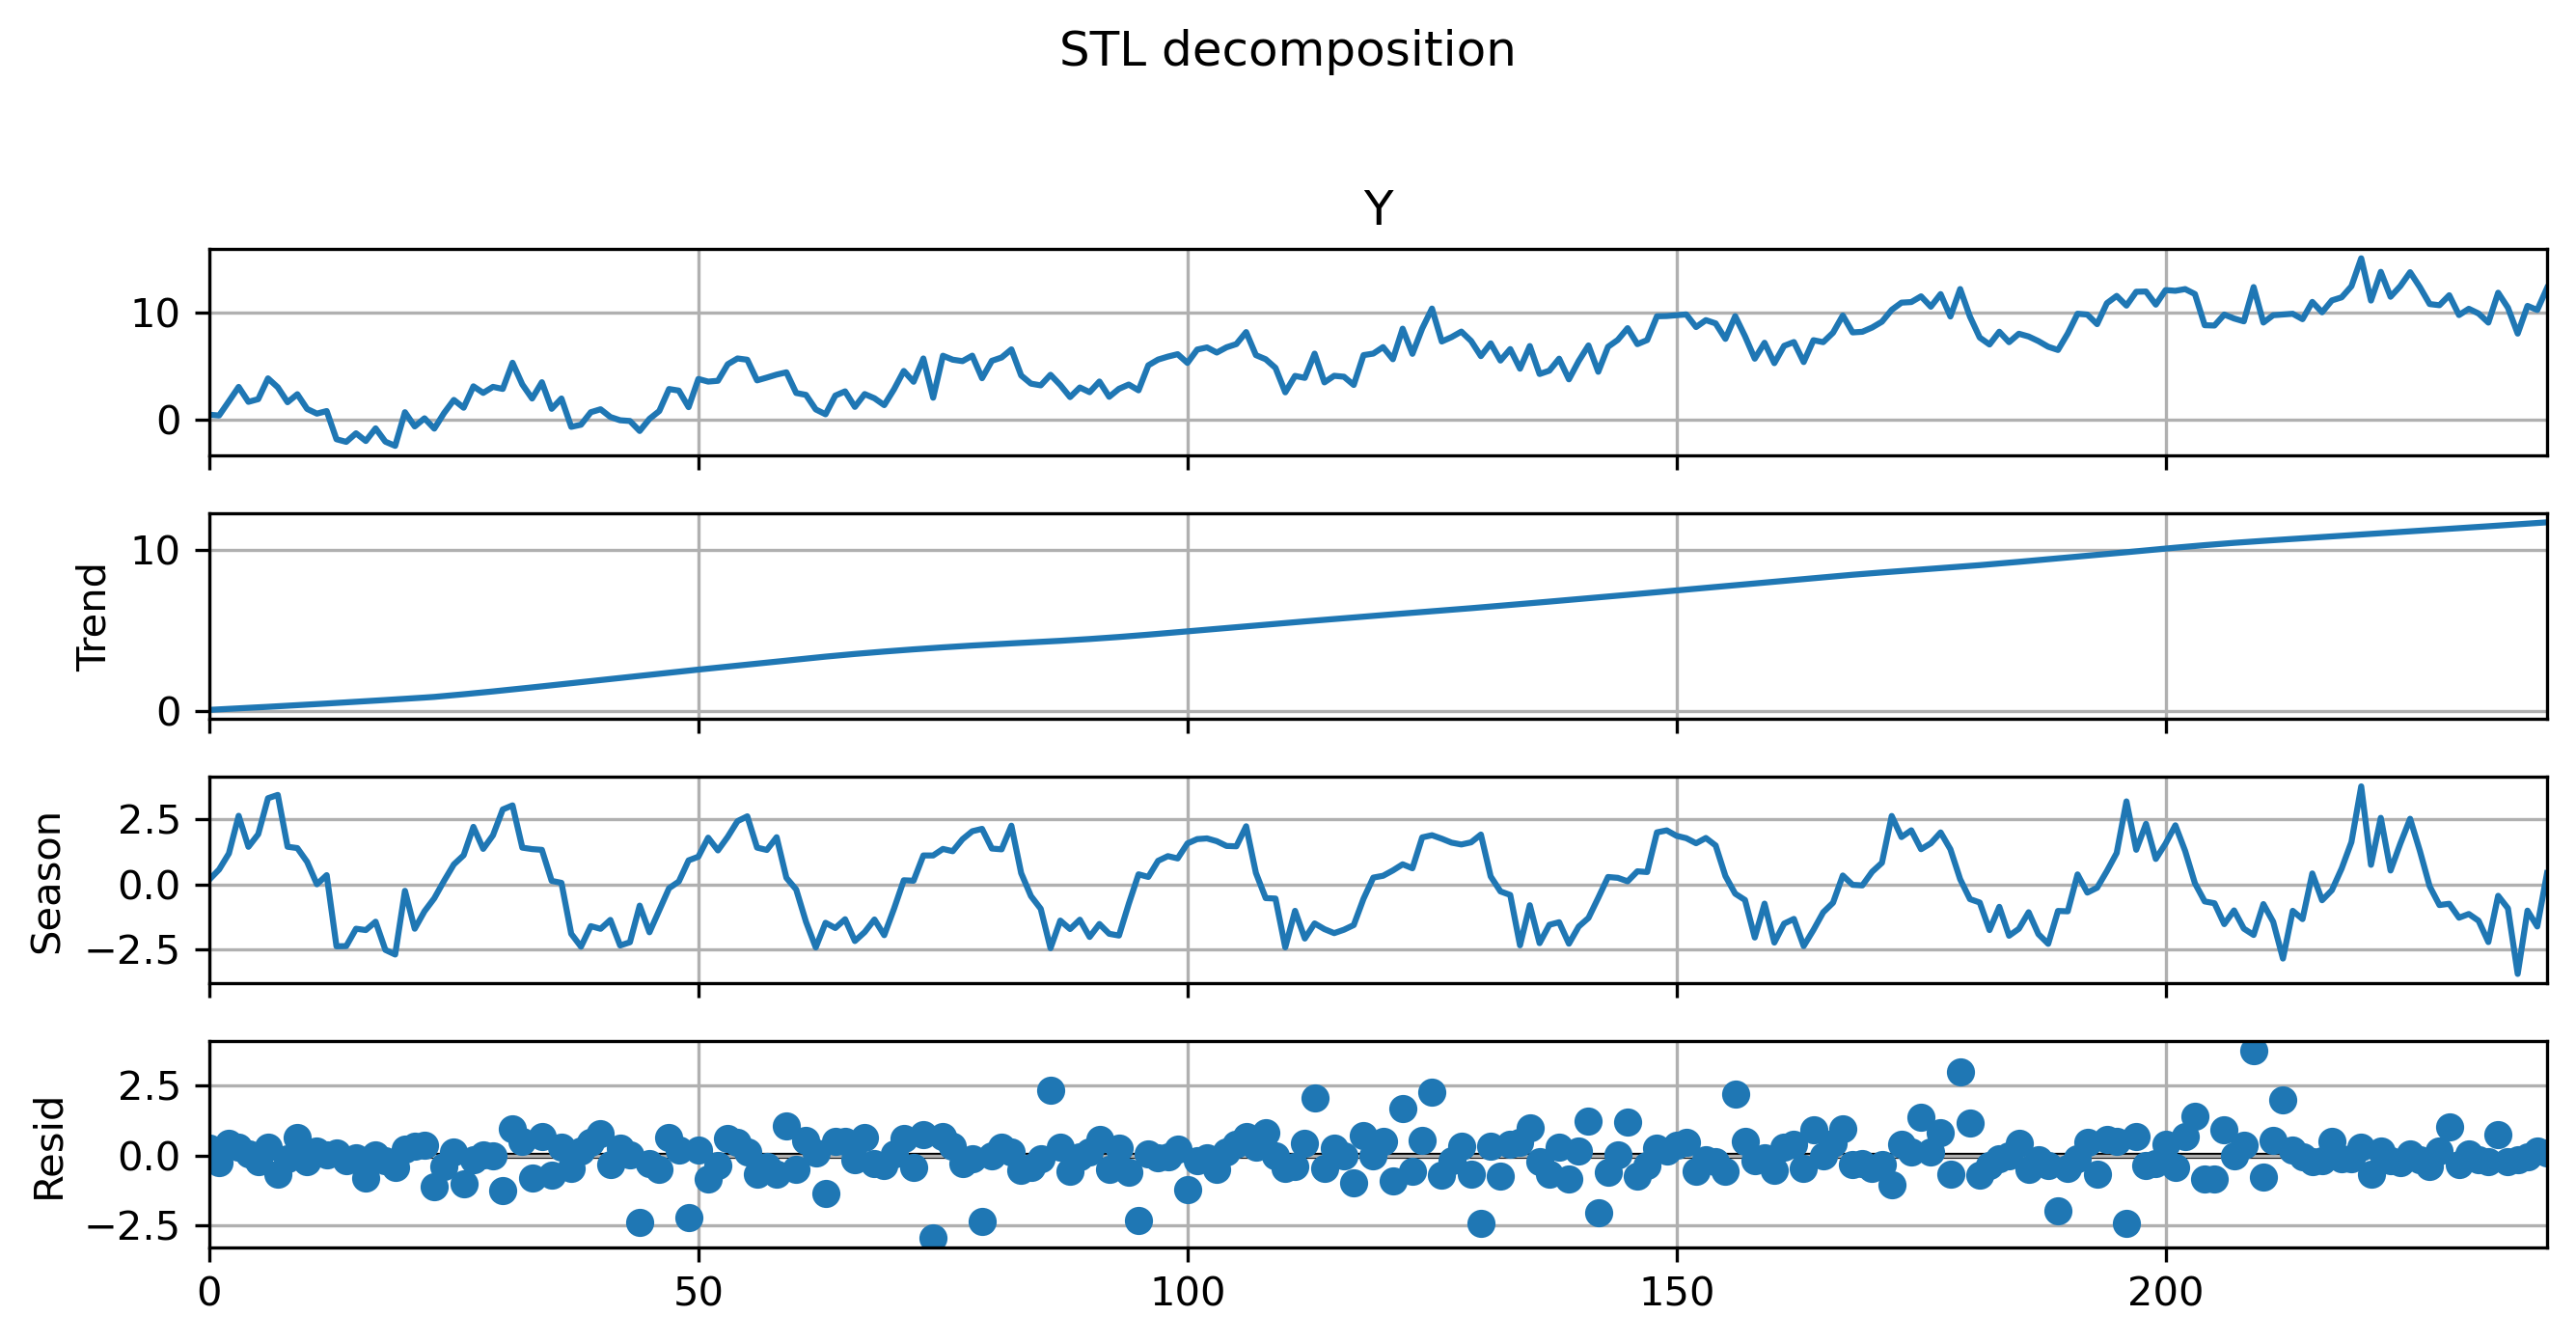

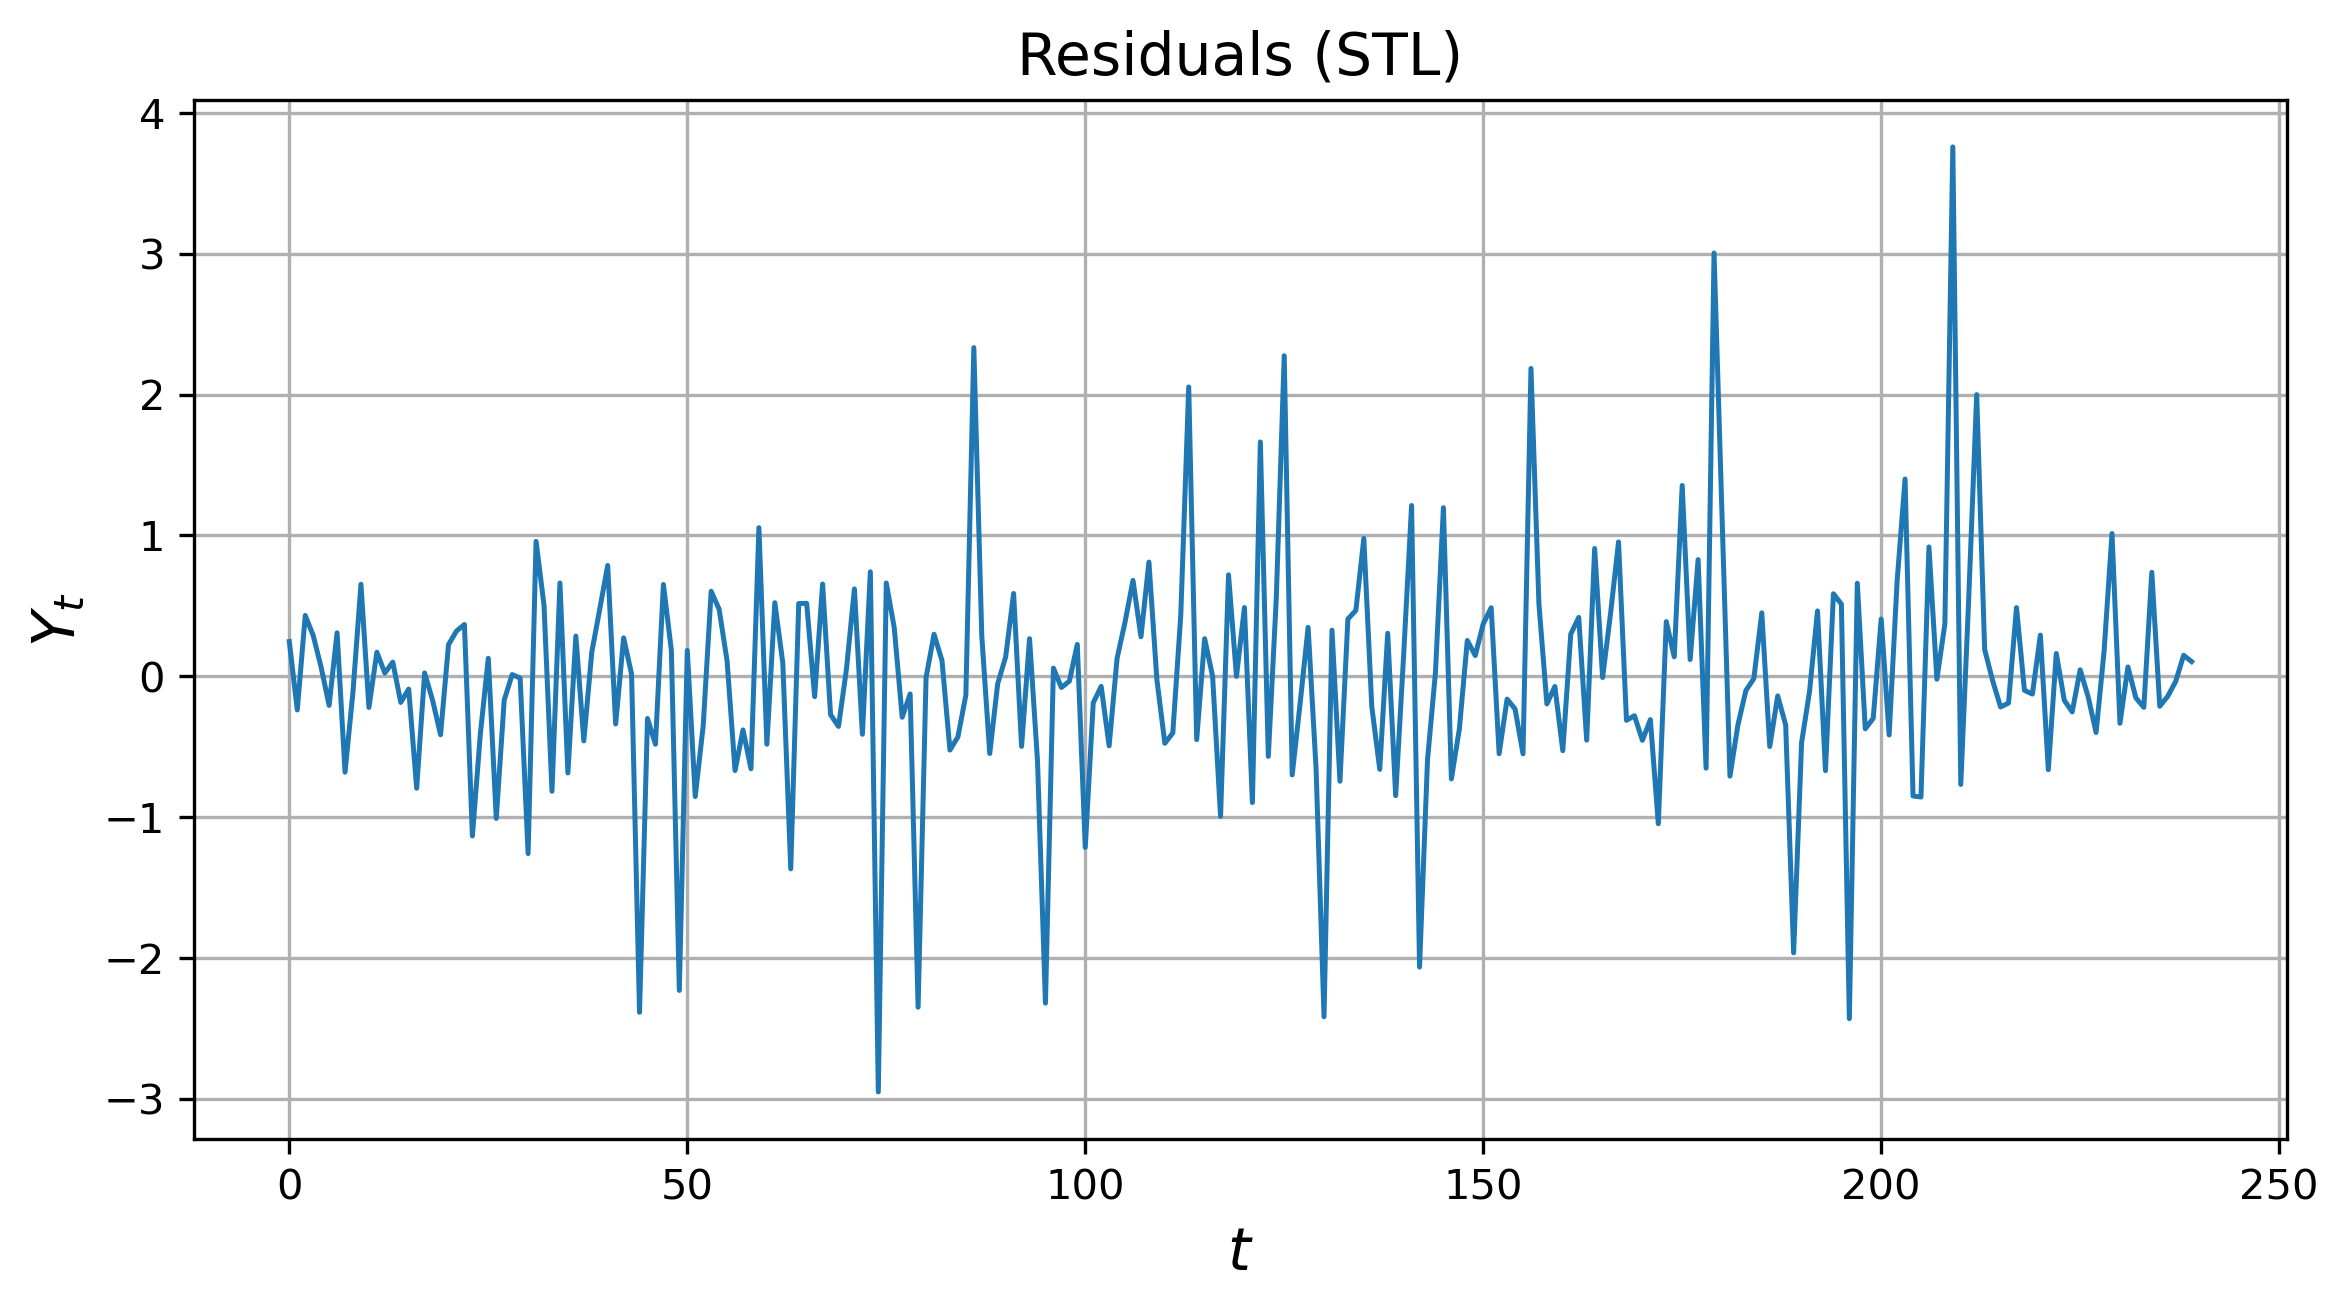

=== Tests for Residuals (STL) ===
ADF: stat=-17.024, p=8.42e-30
 => Reject nonstationarity: series likely stationary in the mean.
KPSS(level): stat=0.348, p=0.0994
 => Fail to reject stationarity: mean appears constant.
ARCH LM: stat=8.354, p=0.594
 => Fail to reject homoskedasticity: variance appears constant.



In [3]:
# Classical additive decomposition
res_classic = seasonal_decompose(ts, model="additive", period=period, two_sided=False)
fig = res_classic.plot()
fig.suptitle("Classical additive decomposition", y=1.02)
plt.tight_layout()
plt.show()

residuals_classic = res_classic.resid.dropna()
show_series(residuals_classic, title="Residuals (classical decomposition)")
summary_tests(residuals_classic, lags=24, name="Residuals (classic)")

# STL decomposition (robust and flexible)
stl = STL(ts, period=period, robust=True)
res_stl = stl.fit()
fig = res_stl.plot()
fig.suptitle("STL decomposition", y=1.02)
plt.tight_layout()
plt.show()

residuals_stl = ts - (res_stl.trend + res_stl.seasonal)
residuals_stl = residuals_stl.dropna()
show_series(residuals_stl, title="Residuals (STL)")
summary_tests(residuals_stl, lags=24, name="Residuals (STL)")


## 3) Differencing approaches

Another simple and very common way to remove nonstationarity is **differencing**.
Instead of modeling trend and seasonality explicitly, we transform the data into
changes relative to past observations.

- **First difference (linear trend):**
  Removes slow-moving trends by focusing on changes between consecutive values:
  $$
  \nabla Y_t = Y_t - Y_{t-1}.
  $$

- **Seasonal difference (periodic component):**
  Removes repeated seasonal patterns by comparing the series with its value one season ago:
  $$
  \nabla_s Y_t = Y_t - Y_{t-s},
  $$
  where $s$ is the seasonal period (e.g., $s=12$ for monthly data with yearly seasonality).

- **Combined differencing:**
  If both a trend and seasonality are present, we can apply them together:
  $$
  \nabla_s \nabla Y_t = (Y_t - Y_{t-1}) - (Y_{t-s} - Y_{t-s-1}).
  $$

---

**Intuition:**
- First differencing removes *drift* (linear growth/decline).
- Seasonal differencing removes *cyclical repetition*.
- After differencing, the transformed series often looks “stationary enough” for forecasting.

---

**In this cell:**
We apply each differencing strategy to the simulated data and then run the WSS tests (ADF, KPSS, Ljung–Box, ARCH LM) on the transformed series.
If the tests suggest stationarity, these differenced series can be used for modeling.

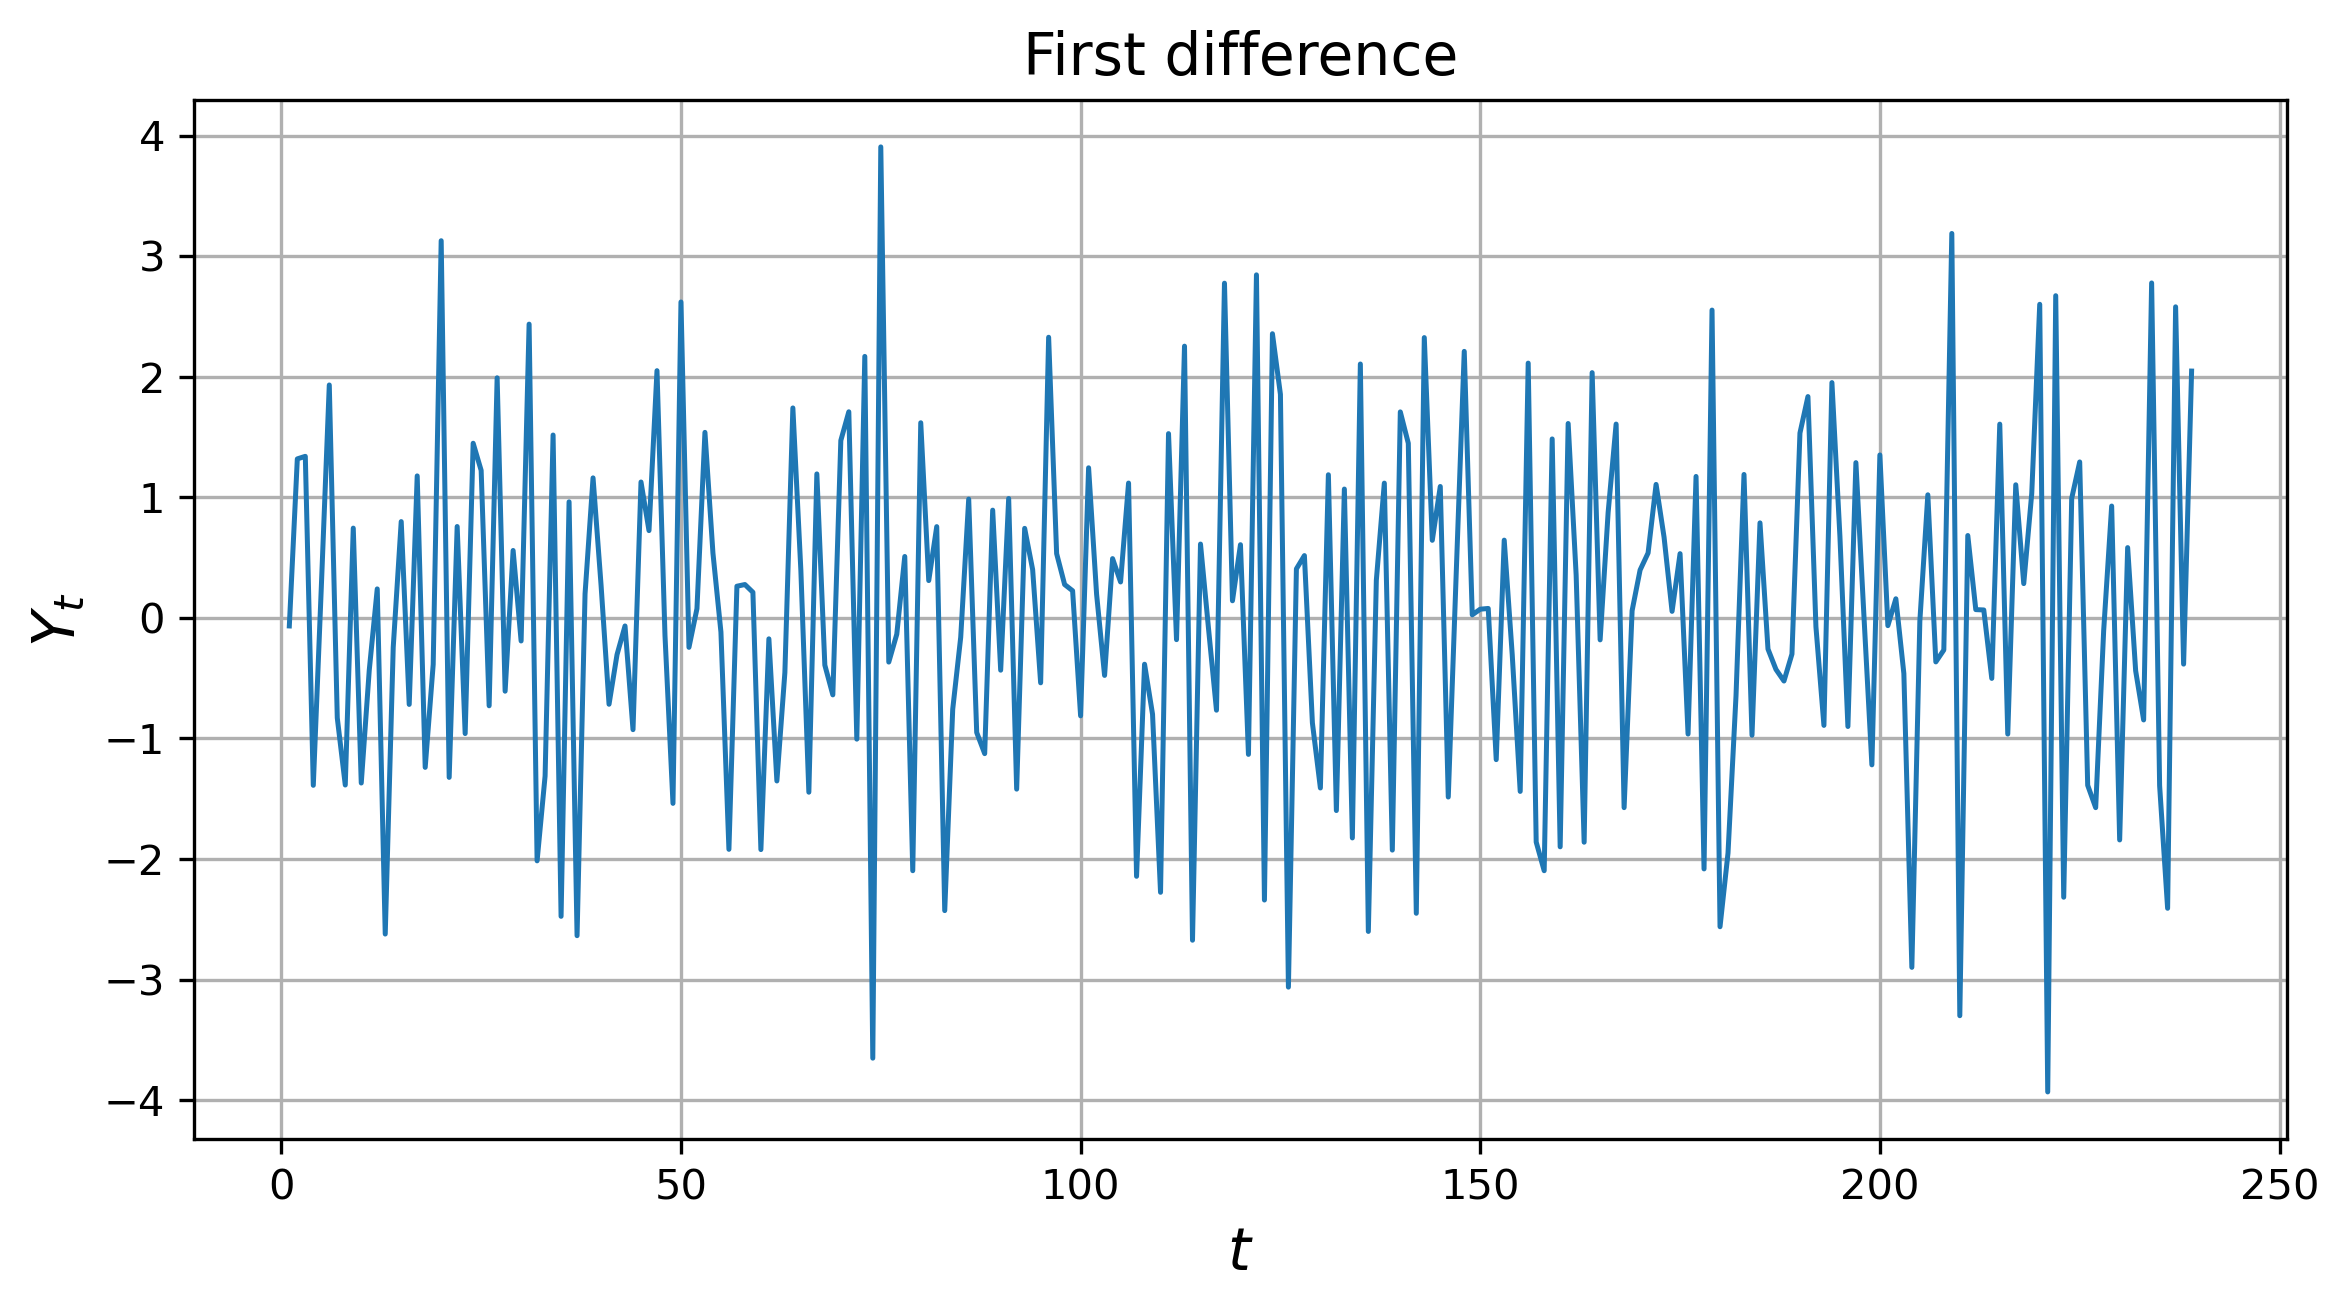

=== Tests for First difference ===
ADF: stat=-9.326, p=9.59e-16
 => Reject nonstationarity: series likely stationary in the mean.
KPSS(level): stat=0.010, p=0.1
 => Fail to reject stationarity: mean appears constant.
ARCH LM: stat=22.173, p=0.0142
 => Reject homoskedasticity: variance changes over time.



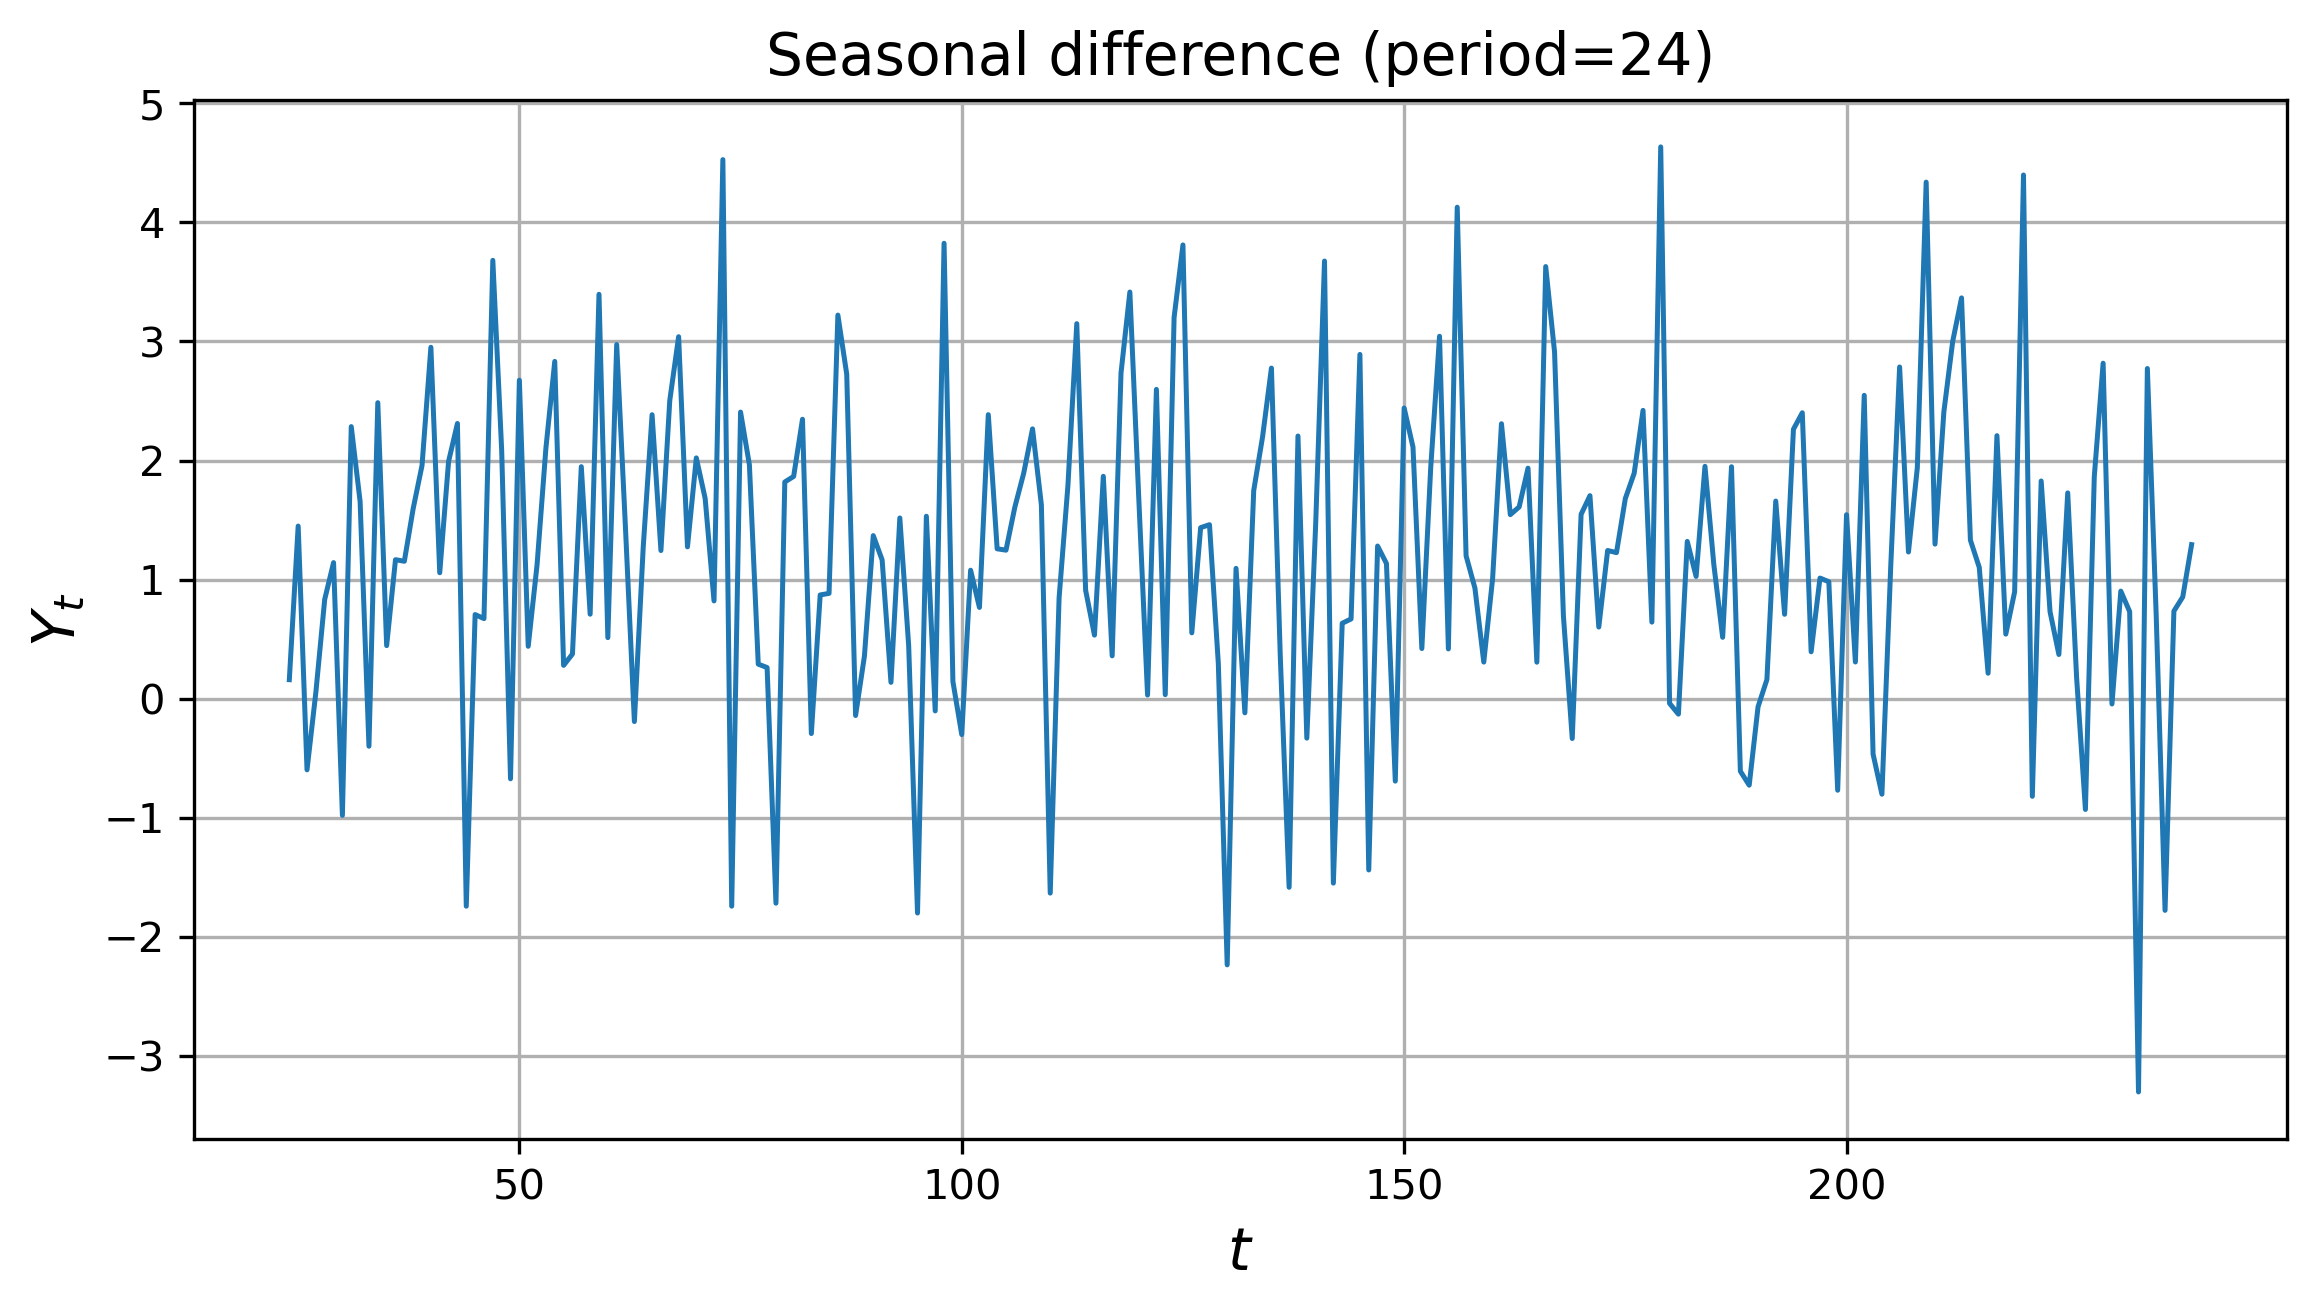

=== Tests for Seasonal difference ===
ADF: stat=-16.156, p=4.52e-29
 => Reject nonstationarity: series likely stationary in the mean.
KPSS(level): stat=0.075, p=0.1
 => Fail to reject stationarity: mean appears constant.
ARCH LM: stat=8.706, p=0.56
 => Fail to reject homoskedasticity: variance appears constant.



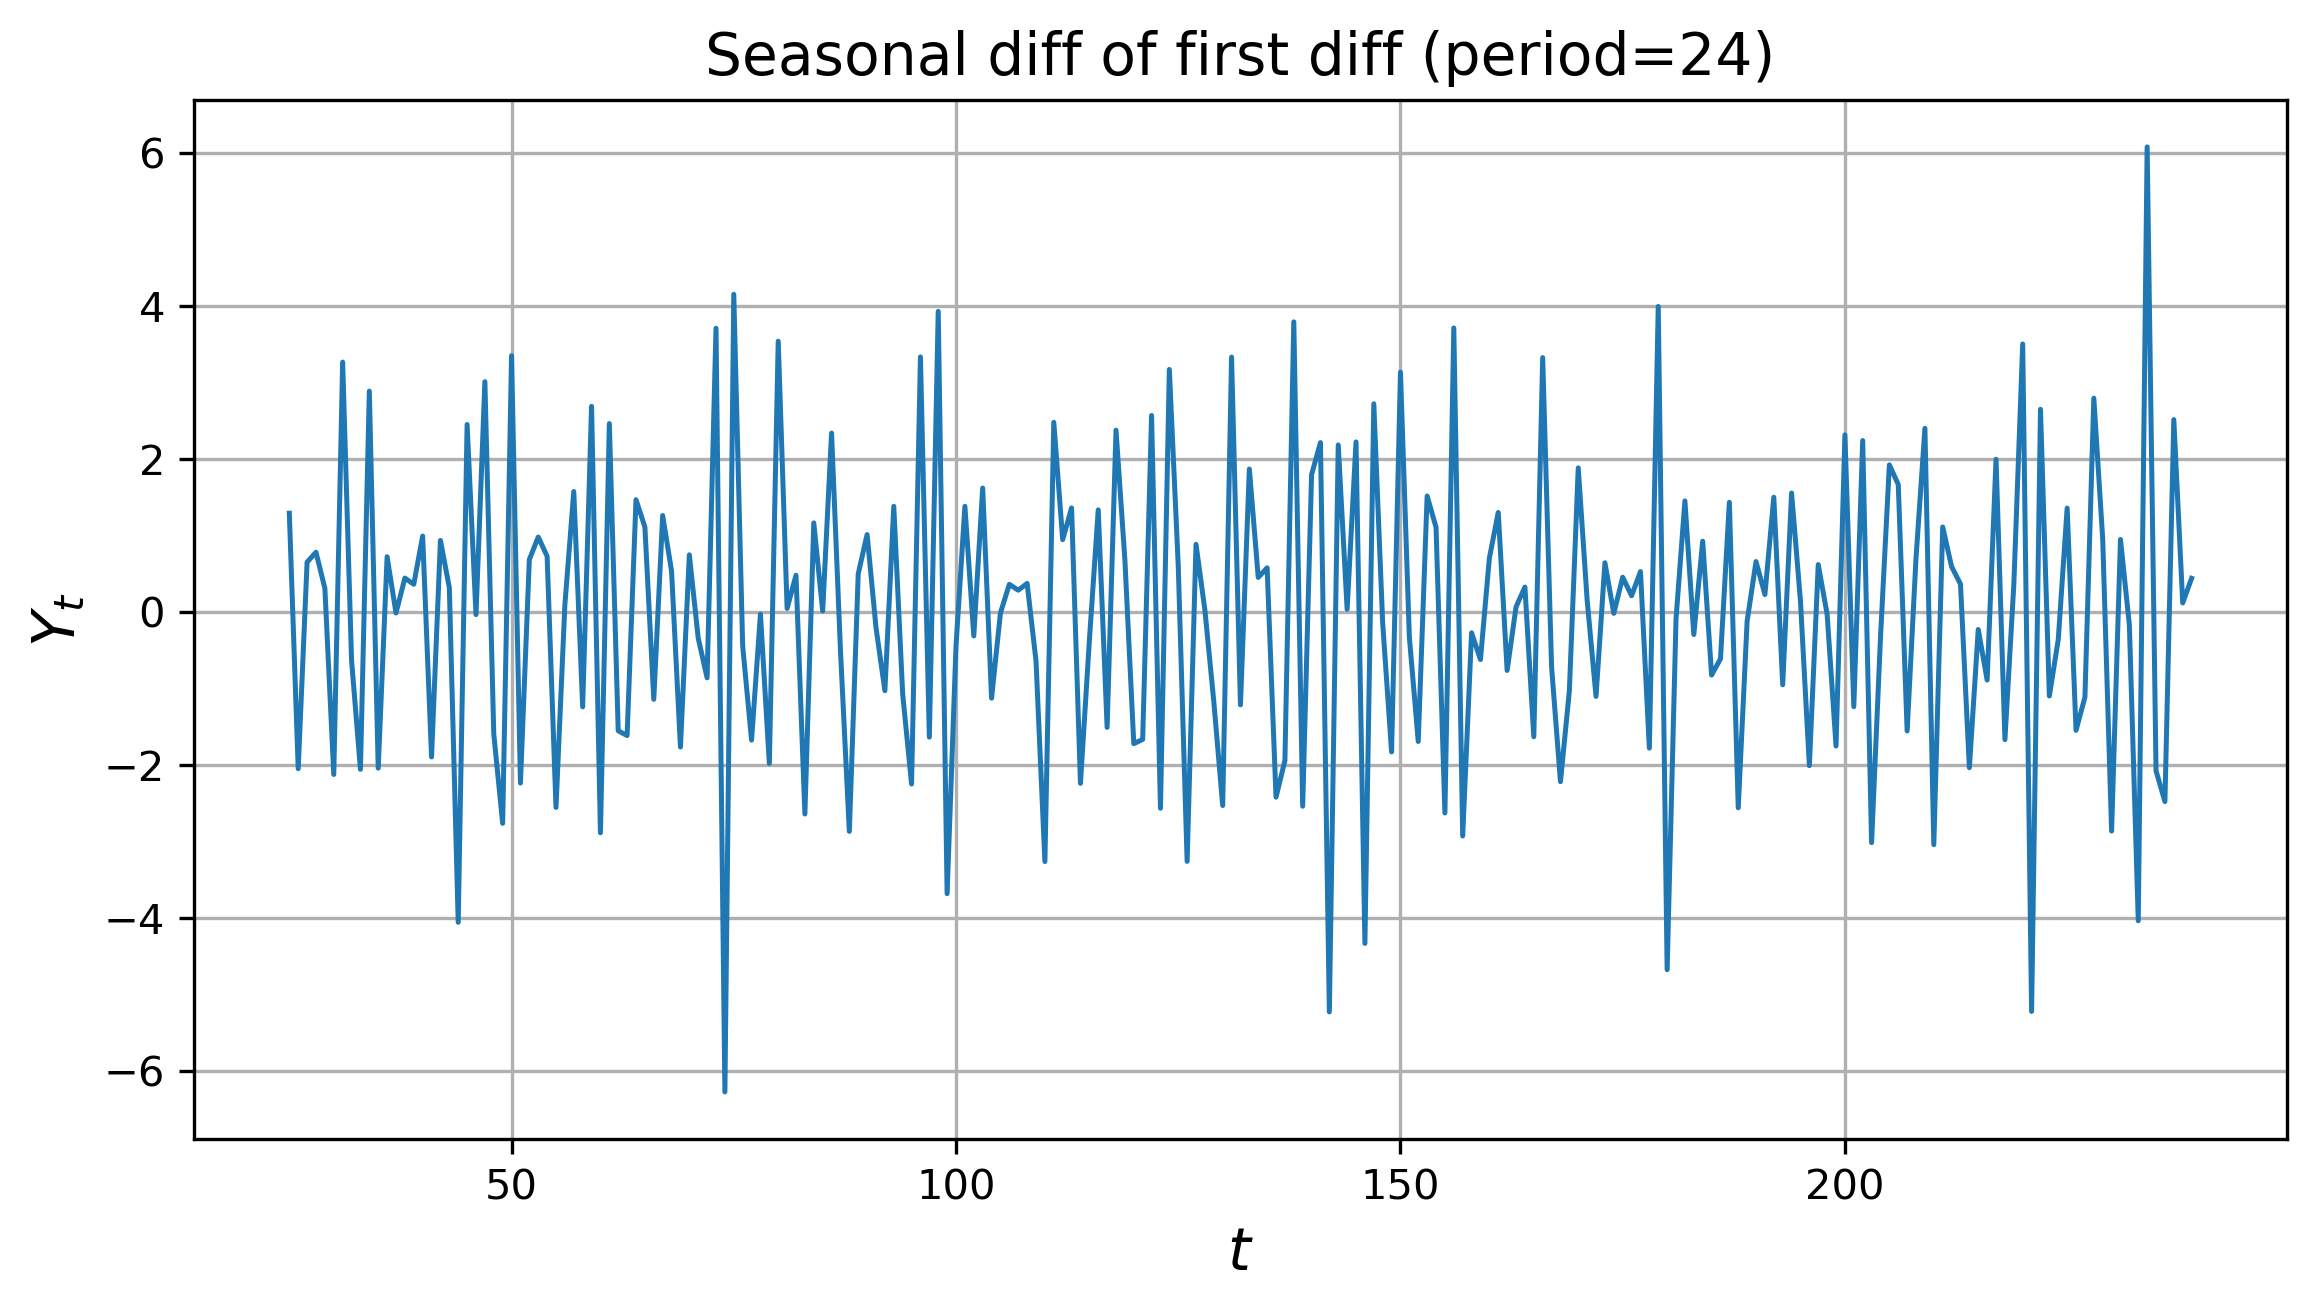

=== Tests for Seasonal+First diff ===
ADF: stat=-7.981, p=2.62e-12
 => Reject nonstationarity: series likely stationary in the mean.
KPSS(level): stat=0.026, p=0.1
 => Fail to reject stationarity: mean appears constant.
ARCH LM: stat=27.961, p=0.00183
 => Reject homoskedasticity: variance changes over time.



In [4]:
d1 = ts.diff().dropna()
ds = ts.diff(period).dropna()
d1ds = d1.diff(period).dropna()

show_series(d1, title="First difference")
summary_tests(d1, lags=24, name="First difference")

show_series(ds, title=f"Seasonal difference (period={period})")
summary_tests(ds, lags=24, name="Seasonal difference")

show_series(d1ds, title=f"Seasonal diff of first diff (period={period})")
summary_tests(d1ds, lags=24, name="Seasonal+First diff")


## 4) Workflow summary

The goal is to transform the raw series into one that is **plausible to satisfy the necessary conditions**
(constant mean, constant variance, and lag-dependent autocovariance).
If these conditions hold, then the one-step-ahead forecasting distribution has a chance
to be shift-invariant and can be more reliably estimated.

**Practical step-by-step strategy:**

1. **Begin with decomposition** (STL or classical)
   → remove visible trend and seasonality, then **test the residuals** with ADF, KPSS, and ARCH LM.

2. **If residuals still fail the conditions:**
   - Apply **differencing** (first and/or seasonal) to eliminate remaining trend or seasonality.

3. **After each adjustment, re-test** until the residuals satisfy the necessary conditions.

4. **Once residuals are plausibly consistent with these conditions:**
   - Use them as the foundation for modeling and forecasting.